In [1]:
# http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/
%matplotlib inline
from pymc3 import *
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [4]:
a = 1; b = 2;
size = 10;
np.random.seed(108727)
x = np.random.normal(0,.4,size = 10)
x.sort()
#x = np.linspace(-1,1,size+1)[:size] + np.random.uniform(0,0.1,size)
#x = np.random.uniform(-1,1,size)

true_y = a + b * x**2

# add noise
y = true_y + np.random.normal(scale=1, size=size)

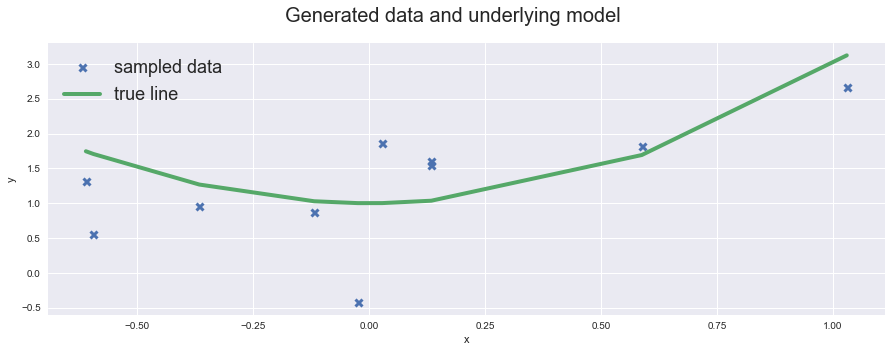

In [5]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
fig.suptitle('Generated data and underlying model', fontsize = 20)
ax.plot(x, y, 'x', label='sampled data', mew = 3)
ax.plot(x, true_y, label='true line', lw=4.)
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc=0, fontsize = 18);

In [6]:
with Model() as m1:
    # Define priors ------------------------------------------------------------
    sigma = Exponential('sigma', 1)
    beta = Normal('beta', 0, sd=5, shape = 2)
    mu = Deterministic('mu', beta[0] + beta[1] * x)
    # Define likelihood --------------------------------------------------------
    likelihood = Normal('y', mu=mu, sd=sigma, observed=y)
    # Inference! ---------------------------------------------------------------
    t1 = sample(3000, njobs=3)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 18.092:   4%|▎         | 7267/200000 [00:01<00:29, 6644.42it/s]
Convergence archived at 7400
Interrupted at 7,400 [3%]: Average Loss = 29.161
100%|██████████| 3500/3500 [00:09<00:00, 378.55it/s]


In [7]:
betasamps = t1[500:]['beta']
betasamps.shape

(7500, 2)

In [8]:
h = np.linspace(-1.5, 1.5, 100)

In [9]:
yhat = betasamps[:,0][:,np.newaxis] + betasamps[:,1][:,np.newaxis] * (h)
ysamps = yhat[np.random.randint(0,7500,10),:].T

yhat = np.percentile(yhat, [2.5,50,97.5],axis = 0)

ml = pm.find_MAP(model = m1)
ymap = ml['beta'][0] + ml['beta'][1] * h

X = np.array([np.ones(10),x]).T
betaml = np.linalg.solve(np.matmul(X.T,X), np.matmul(X.T,y))
yml = np.matmul(np.array([np.ones(100),h]).T, betaml)

Optimization terminated successfully.
         Current function value: 15.582424
         Iterations: 12
         Function evaluations: 16
         Gradient evaluations: 16


In [10]:
def plot_regression(yhat, ymap, yml, ysamps):
    plt.figure(figsize=(15, 5));
    
    plt.fill_between(h, yhat[0], yhat[2], facecolor='gray', alpha = 0.4, zorder = 1);
    plt.plot(h, yhat[1], label = 'Median curve', lw=3., c='b', linestyle=':', zorder = 1);
    plt.plot(h, ymap, label='MAP curve', lw=3., c='g', zorder = 1);
    plt.plot(h, yml, label='MLE curve', lw=3., c='k', zorder = 1);
    plt.plot(h, ysamps.mean(axis=1), c = 'orange', lw = 3, label = 'Sample mean',zorder = 1);
    plt.plot(h, ysamps[:,0], label = 'Sample line',c = 'k', alpha = .3, linestyle = '--', zorder = 1);
    plt.plot(h, ysamps[:,1:], c = 'k', alpha = .3, linestyle = '--', zorder = 1);
#    plt.plot(x, true_y, label='true regression line', lw=2., c='r', linestyle ='--', zorder = 1);
    plt.scatter(x, y,  marker = '.', c = 'r', s = 150, zorder = 2);
    
    plt.title('Posterior predictive regression lines', fontsize = 20)
    plt.legend(bbox_to_anchor=(0.5, -0.2), loc=9,
                   ncol=2, mode="expand", borderaxespad=0., fontsize = 18);
    plt.ylim([-1,10])

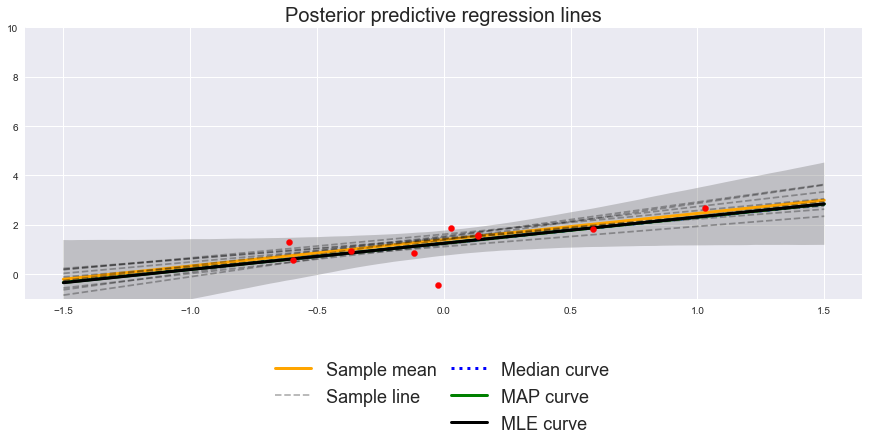

In [11]:
plot_regression(yhat, ymap, yml, ysamps)

In [134]:
v = np.linspace(-1.5, 10, 150)
Xh, Yv = np.meshgrid(h, v)

In [135]:
mu = betasamps.mean(axis=0)
sigma = np.cov(betasamps.T)

In [136]:
phi = np.matmul(np.c_[np.ones(100),h], mu) 
eta = np.diag(np.matmul(np.c_[np.ones(100),h],np.matmul(sigma, np.c_[np.ones(100),h].T)))
Zhv = (np.exp(-0.5*(v[:,np.newaxis] - phi)**2/eta)/np.sqrt(2*np.pi))/np.sqrt(eta)

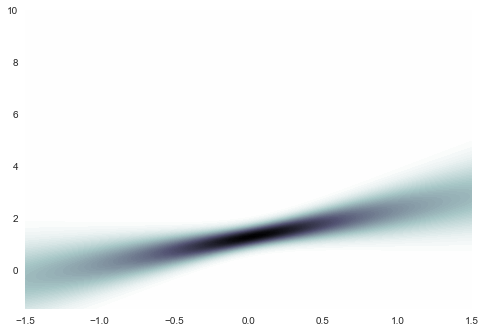

In [138]:
plt.contourf(Xh, Yv, Zhv, 100, cmap = 'bone_r');

In [139]:
mu = betasamps.mean(axis=0)
sigma = np.cov(betasamps.T)

In [140]:
N = 60
X = np.linspace(-3, 3, N)
Y = np.linspace(-3, 4, N)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

In [141]:
F = multivariate_normal(mu, sigma)
Z = F.pdf(pos)

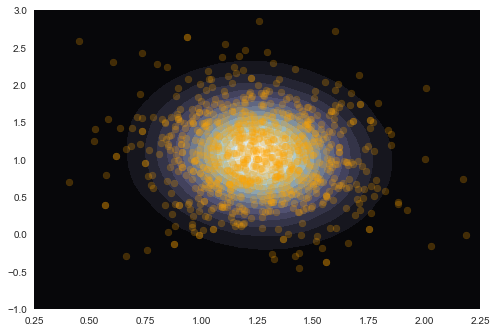

In [142]:
index = np.random.randint(0,7500,1000)
plt.contourf(X, Y, Z, 15, cmap = 'bone');
plt.scatter(betasamps[index,0], betasamps[index,1], c = 'orange', alpha = .24)
plt.ylim(-1,3);
plt.xlim(.25,2.25);

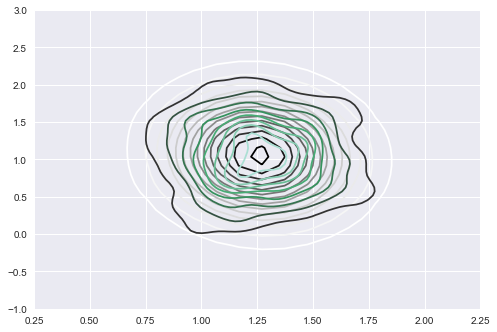

In [143]:
plt.contour(X, Y, Z, 15);
sns.kdeplot(betasamps[index,0], betasamps[index,1])
plt.ylim(-1,3);
plt.xlim(.25,2.25);

In [144]:
with m1:
    advi = pm.fit(10000, method = 'fullrank_advi')

Average Loss = -inf: 100%|██████████| 10000/10000 [00:04<00:00, 2499.25it/s] 
Finished [100%]: Average Loss = -6.8561e+07


In [145]:
F = multivariate_normal(advi.sample()['beta'].mean(0), np.cov(advi.sample()['beta'].T))
Z = F.pdf(pos)

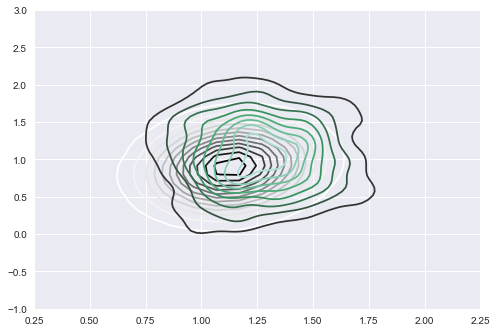

In [146]:
plt.contour(X, Y, Z, 15);
sns.kdeplot(betasamps[index,0], betasamps[index,1])
plt.ylim(-1,3);
plt.xlim(.25,2.25);

In [147]:
F = multivariate_normal(advi.mean.eval()[1:3], advi.cov.eval()[1:3,1:3])
Z = F.pdf(pos)

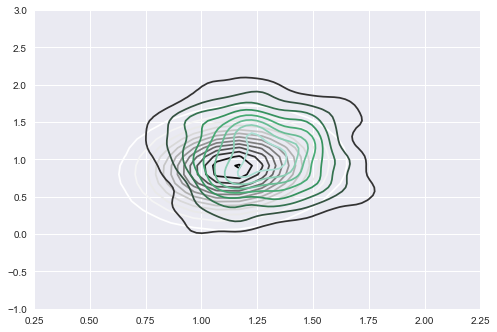

In [148]:
plt.contour(X, Y, Z, 15);
sns.kdeplot(betasamps[index,0], betasamps[index,1])
plt.ylim(-1,3);
plt.xlim(.25,2.25);

In [149]:
M = 100; 
F = 20;

In [150]:
def GPanimation(M,F):
    x = np.random.normal(size = M)
    r = np.linalg.norm(x)
    x = x/r
    t = np.random.normal(size = M)
    t = t - np.dot(t,x) * x 
    t = t/np.linalg.norm(t)
    s = np.linspace(0, 2*np.pi,F+1)
    s = s[:-1]
    t = np.outer(t,s)

    D = t.shape[0]
    theta = np.linalg.norm(t,axis = 0)
    S = np.outer(x, np.cos(theta)) + t * np.repeat((np.sin(theta)/theta)[np.newaxis,:],D,axis=0)
    S[:,0] = x
    S = r * S
    return S

In [151]:
s1 = GPanimation(M,F)

In [152]:
phi = np.c_[np.ones(100), h]

In [153]:
from matplotlib import animation, rc
from IPython.display import HTML

In [189]:
fig, ax = plt.subplots(figsize=(15,5));
ax.contourf(Xh, Yv, Zhv, 100, cmap = 'bone_r',zorder=1);
ax.set_xlim(( -1.5, 1.5));
ax.set_ylim(( -1, 10));
ax.scatter(x, y,  marker = '.', c = 'r', s = 150, zorder = 3);
ax.fill_between(h, yhat[0], yhat[2], facecolor='gray', alpha = 0.1, zorder = 2);
line, = ax.plot([], [],lw=2, linestyle = '--');
plt.close()

In [181]:
def init():
    line.set_data([], [])
    return (line,)

In [182]:
def animate(i):
    line.set_data(h, np.matmul(phi,mu) + np.matmul(L,s1[:,i]))
    return (line,)

In [183]:
K = np.matmul(phi,np.matmul(sigma, phi.T))
L = np.linalg.cholesky(K + 1e-8 * np.identity(100))

In [190]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=20, interval=100, blit=True)

In [191]:
HTML(anim.to_html5_video())

In [192]:
with Model() as m3:
    # Define priors ------------------------------------------------------------
    sigma = Exponential('sigma', 1)
    beta = Normal('beta', 0, sd=5, shape = 4)
    mu = Deterministic('mu', beta[0] + beta[1] * x + beta[2] * x**2 + beta[3] * x**3)
    # Define likelihood --------------------------------------------------------
    likelihood = Normal('y', mu=mu, sd=sigma, observed=y)

with m3:
    start = pm.find_MAP(model = m3)
    # Inference! ---------------------------------------------------------------
    t3 = sample(3000, njobs=3, start = start)

Optimization terminated successfully.
         Current function value: 19.927454
         Iterations: 15
         Function evaluations: 19
         Gradient evaluations: 19


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 22.477:   3%|▎         | 5333/200000 [00:00<00:33, 5896.83it/s]
Convergence archived at 5600
Interrupted at 5,600 [2%]: Average Loss = 33.459
100%|██████████| 3500/3500 [00:19<00:00, 182.61it/s]
/Users/alfredogarbuno/anaconda2/envs/py2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:473: UserWarning: Chain 1 contains 1 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
/Users/alfredogarbuno/anaconda2/envs/py2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:473: UserWarning: Chain 2 contains 1 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))


In [193]:
betasamps = t3[500:]['beta']
degree = betasamps.shape[1]

H = np.c_[np.ones(100),h,h**2,h**3]
yhat = np.matmul(betasamps, H.T)
ysamps = yhat[np.random.randint(0,7500,10),:].T
yhat = np.percentile(yhat, [2.5,50,97.5],axis = 0)

ml = pm.find_MAP(model = m3)
ymap = np.matmul(ml['beta'],H.T)

X = np.array([np.ones(10),x, x**2, x**3]).T
betaml = np.linalg.solve(np.matmul(X.T,X), np.matmul(X.T,y))
yml = np.matmul(np.array([np.ones(100),h, h**2, h**3]).T, betaml)

Optimization terminated successfully.
         Current function value: 19.927454
         Iterations: 15
         Function evaluations: 19
         Gradient evaluations: 19


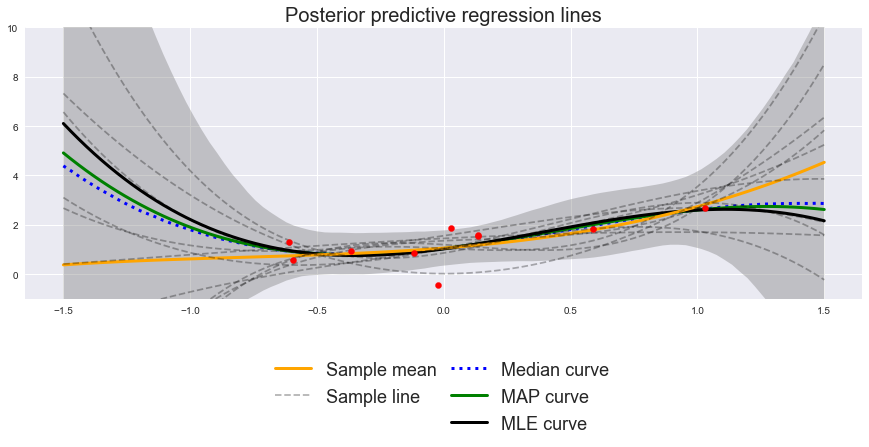

In [194]:
plot_regression(yhat, ymap, yml,ysamps)

In [195]:
with m3:
    advi = pm.fit(10000, method = 'fullrank_advi')

Average Loss = -inf: 100%|██████████| 10000/10000 [00:04<00:00, 2466.48it/s]  
Finished [100%]: Average Loss = -9.6354e+07


In [221]:
mu = advi.mean.eval()[1:5]
sigma = advi.cov.eval()[1:5,1:5]

mu = betasamps.mean(axis=0)
sigma = np.cov(betasamps.T)
phi = H

In [222]:
K = np.matmul(phi,np.matmul(sigma, phi.T))
L = np.linalg.cholesky(K + 1e-8 * np.identity(100))

In [223]:
s1 = GPanimation(M,F)
s2 = GPanimation(M,F)
s3 = GPanimation(M,F)
s4 = GPanimation(M,F)

In [224]:
s = [s1, s2, s3, s4]

In [225]:
fig, ax = plt.subplots(figsize=(15,5));
ax.set_xlim(( -1.5, 1.5));
ax.set_ylim(( -1, 10));
ax.scatter(x, y,  marker = '.', c = 'r', s = 150, zorder = 2);
ax.fill_between(h, yhat[0], yhat[2], facecolor='gray', alpha = 0.4, zorder = 1);

N = 4
lines = [plt.plot([], [],linestyle='--', c = 'k',alpha=.3)[0] for _ in range(N)]

plt.close()

In [226]:
def init():    
    for line in lines:
        line.set_data([], [])
    return lines

In [227]:
def animate(i):
    for j,line in enumerate(lines):
        line.set_data(h, np.matmul(phi,mu) + np.matmul(L,s[j][:,i]))
    return lines

In [228]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=20, interval=100, blit=True)

In [229]:
HTML(anim.to_html5_video())

In [230]:
s = list()
nsamps = 10
for i in range(nsamps):
    s.append(GPanimation(M,F))

In [237]:
eta = np.diag(np.matmul(H,np.matmul(sigma, H.T)))
Zhv = (np.exp(-0.5*(v[:,np.newaxis] - np.matmul(H, mu) )**2/eta)/np.sqrt(2*np.pi))/np.sqrt(eta)

In [238]:
fig, ax = plt.subplots(figsize=(15,5));
ax.contourf(Xh, Yv, Zhv, 100, cmap = 'bone_r',zorder=1);
ax.set_xlim(( -1.5, 1.5));
ax.set_ylim(( -1, 10));
ax.scatter(x, y,  marker = '.', c = 'k', s = 150, zorder = 3);
ax.fill_between(h, yhat[0], yhat[2], facecolor='gray', alpha = 0.4, zorder = 1);
plt.plot(h, yhat[1], lw=3., c='b', linestyle=':', zorder = 1);


N = nsamps
lines = [plt.plot([], [],linestyle='--', c = 'k',alpha=.3, zorder=2)[0] for _ in range(N)]
lines.append(plt.plot([], [],linestyle='--', c = 'r',alpha=.8,lw=3.,zorder=2)[0])

plt.close()

In [239]:
def init():    
    for line in lines:
        line.set_data([], [])
    return lines

In [240]:
def animate(i):
    for j,line in enumerate(lines):
        if j < nsamps:
            line.set_data(h, np.matmul(phi,mu) + np.matmul(L,s[j][:,i]))
        else:
            line.set_data(h, np.matmul(phi,mu) + np.matmul(L,np.array(s).mean(axis=0)[:,i]))
    return lines

In [241]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=20, interval=100, blit=True)

In [242]:
HTML(anim.to_html5_video())

In [243]:
with Model() as m7:
    # Define priors ------------------------------------------------------------
    sigma = Exponential('sigma', 1)
    beta = Normal('beta', 0, sd=5e0, shape = 8)
    mu = Deterministic('mu', beta[0] + beta[1] * x + beta[2] * x**2 + beta[3] * x**3 + \
                       beta[4] * x**4 + beta[5] * x**5 + beta[6] * x**6 + beta[7] * x**7)
    # Define likelihood --------------------------------------------------------
    likelihood = Normal('y', mu=mu, sd=sigma, observed=y)
    
with m7:    
    # Inference! ---------------------------------------------------------------
    start = pm.find_MAP(model = m7)
    t7 = sample(3000, njobs=3)

Optimization terminated successfully.
         Current function value: 29.991660
         Iterations: 29
         Function evaluations: 35
         Gradient evaluations: 35


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 29.379:   3%|▎         | 5642/200000 [00:01<00:38, 5006.02it/s]
Convergence archived at 5700
Interrupted at 5,700 [2%]: Average Loss = 41.24
 78%|███████▊  | 2733/3500 [01:03<00:17, 45.04it/s]/Users/alfredogarbuno/anaconda2/envs/py2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:473: UserWarning: Chain 1 contains 67 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
 97%|█████████▋| 3410/3500 [01:18<00:01, 45.99it/s]/Users/alfredogarbuno/anaconda2/envs/py2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:473: UserWarning: Chain 2 contains 22 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 3500/3500 [01:20<00:00, 43.83it/s]/Users/alfredogarbuno/anaconda2/envs/py2/lib/python2.7/site-packages/pymc

In [244]:
betasamps = t7[500:]['beta']
degree = betasamps.shape[1]

H = np.c_[np.ones(100),h,h**2,h**3,h**4, h**5, h**6, h**7]
yhat = np.matmul(betasamps, H.T)
ml = pm.find_MAP(model = m7)
ymap = np.matmul(ml['beta'],H.T)
ysamps = yhat[np.random.randint(0,7500,10),:].T
yhat = np.percentile(yhat, [2.5,50,97.5],axis = 0)

X = np.array([np.ones(10),x, x**2, x**3, x**4, x**5, x**6]).T
betaml = np.linalg.solve(np.matmul(X.T,X), np.matmul(X.T,y))
yml = np.matmul(np.array([np.ones(100),h, h**2, h**3, h**4, h**5, h**6]).T, betaml)

Optimization terminated successfully.
         Current function value: 29.991660
         Iterations: 29
         Function evaluations: 35
         Gradient evaluations: 35


In [245]:
mu = betasamps.mean(axis=0)
sigma = np.cov(betasamps.T)
phi = H

In [246]:
K = np.matmul(phi,np.matmul(sigma, phi.T))
L = np.linalg.cholesky(K + 1e-8 * np.identity(100))

In [247]:
s = list()
nsamps = 10
for i in range(nsamps):
    s.append(GPanimation(M,F))

In [248]:
eta = np.diag(np.matmul(H,np.matmul(sigma, H.T)))
Zhv = (np.exp(-0.5*(v[:,np.newaxis] - np.matmul(H, mu) )**2/eta)/np.sqrt(2*np.pi))/np.sqrt(eta)

In [254]:
fig, ax = plt.subplots(figsize=(15,5));
ax.contourf(Xh, Yv, Zhv, 100, cmap = 'bone_r',zorder=1);
ax.set_xlim(( -1.5, 1.5));
ax.set_ylim(( -1, 10));
ax.scatter(x, y,  marker = '.', c = 'k', s = 150, zorder = 3);
#ax.fill_between(h, yhat[0], yhat[2], facecolor='gray', alpha = 0.4, zorder = 1);
plt.plot(h, yhat[1], lw=3., c='b', linestyle=':', zorder = 1);


N = nsamps
lines = [plt.plot([], [],linestyle='--', c = 'k',alpha=.3, zorder=2)[0] for _ in range(N)]
lines.append(plt.plot([], [],linestyle='--', c = 'r',alpha=.8,lw=3.,zorder=2)[0])

plt.close()

In [255]:
def init():    
    for line in lines:
        line.set_data([], [])
    return lines

In [256]:
def animate(i):
    for j,line in enumerate(lines):
        if j < nsamps:
            line.set_data(h, np.matmul(phi,mu) + np.matmul(L,s[j][:,i]))
        else:
            line.set_data(h, np.matmul(phi,mu) + np.matmul(L,np.array(s).mean(axis=0)[:,i]))
    return lines

In [257]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=20, interval=100, blit=True)

In [258]:
HTML(anim.to_html5_video())